In [6]:
import scripts.schedgen as sg
import scripts.schedsim as sm

import os
import shutil
import matplotlib.pyplot as plt
from functools import reduce
import polars as pl
import subprocess
import sys
import itertools
import concurrent.futures
from io import StringIO

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)

SCHEDVIEW = "./build/schedview/schedview"
gen = sg.SchedGen("./build/schedgen/schedgen")
sim = sm.SchedSimRunner("./build/schedsim/schedsim")

In [7]:
PLATFORM = "./platforms/exynos5422.json"
DIR = "alloc_tasksets"

# Generate the tasksets

In [3]:
if os.path.isdir(DIR):
    shutil.rmtree(DIR)

os.mkdir(DIR)
for i in range(1, 81):
    data_path = DIR + "/" + str(i)
    os.mkdir(data_path)
    for j in range(1, 101):
        gen.generate_taskset(
            tasks  = 10,
            totalu = i/10,
            umax   = 0.9,
            success = 1,
            compression = 1,
            output = (data_path + "/" + str(j) + ".json"))

# Simulate the tasksets

In [4]:
for alloc in ["little_first", "big_first", "smart_ass"]:
    for sched in ["grub", "ffa", "csf"]:
        print(f"-> {alloc} {sched}")
        sim.simul(DIR, alloc, sched, PLATFORM)

-> little_first grub
-> little_first ffa
-> little_first csf
-> big_first grub
-> big_first ffa
-> big_first csf
-> smart_ass grub
-> smart_ass ffa
-> smart_ass csf


# Logs analysis

In [5]:
def call_cmpt(log, index):
    args = [SCHEDVIEW, "--platform", PLATFORM, log, "--frequency"]
    if index:
        args.append("--index")
    return subprocess.run(args, capture_output=True, text=True, check=True).stdout

def read_csv_to_dataframe(csv_data):
    df = pl.read_csv(StringIO(csv_data), separator=';')
    df = df.with_columns(
        (pl.col('stop') - pl.col('start')).alias('duration')
    )
    
    return df

def compute_cluster_stats(df):
    distribution = df.group_by(['cluster_id', 'freq']).agg([
        pl.col('duration').sum().alias('total_duration'),
        pl.col('duration').mean().alias('avg_duration'),
        pl.col('duration').count().alias('count'),
        pl.col('duration').min().alias('min_duration'),
        pl.col('duration').max().alias('max_duration')
    ])
    
    return distribution

def combine_distributions(distribution_list):
    combined_distribution = (
        pl.concat(distribution_list)
        .group_by(['cluster_id', 'freq'])
        .agg([
            pl.col('total_duration').sum().alias('total_duration'),
            pl.col('count').sum().alias('count'),
            pl.col('min_duration').min().alias('min_duration'),
            pl.col('max_duration').max().alias('max_duration'),
            (pl.col('total_duration').sum() / pl.col('count').sum()).alias('avg_duration')
        ])
        .sort(['cluster_id', 'freq'])
    )
    
    return combined_distribution

def compute_avg_freq_by_utilization(results):
    avg_freq_data = []

    for util_step, distribution in enumerate(results, start=1):
        utilization = util_step * 0.1
        avg_freq_by_cluster = (
            distribution
            .group_by('cluster_id')
            .agg([
                ((pl.col('freq') * pl.col('total_duration')).sum() / 
                 pl.col('total_duration').sum()).alias('avg_frequency'),
                pl.col('total_duration').sum().alias('total_duration_sum'),
                pl.col('count').sum().alias('total_count')
            ])
        )

        avg_freq_by_cluster = avg_freq_by_cluster.with_columns(
            pl.lit(utilization).alias('utilization')
        )
        avg_freq_data.append(avg_freq_by_cluster)
    
    final_df = (
        pl.concat(avg_freq_data)
        .select([
            'utilization',
            'cluster_id',
            'avg_frequency',
            'total_duration_sum',
            'total_count'
        ])
        .sort(['utilization', 'cluster_id'])
    )
    
    return final_df

def average_freq(logs_name):
    results = []
    total = 81
    for j in range(1, total):
        util_results = []
        for i in range(1, 101):
            target = f"{logs_name}/{j}/{i}.json"
            raw_data = read_csv_to_dataframe(call_cmpt(target, True))
            util_results.append(compute_cluster_stats(raw_data))
        
        results.append(combine_distributions(util_results))

    return compute_avg_freq_by_utilization(results)

In [6]:
allocations = ["little_first", "big_first", "smart_ass"]
schedulers = ["grub", "ffa", "csf"]

combinations = list(itertools.product(allocations, schedulers))

def worker(alloc, sched):
    freq = average_freq(f"{DIR}_logs_{alloc}_{sched}").rename({"avg_frequency": f"avg_frequency_{alloc}_{sched}"})
    return (alloc, sched, freq)

with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all tasks to the thread pool
    futures = [executor.submit(worker, alloc, sched) for alloc, sched in combinations]
    # Collect results as they complete
    results = [future.result() for future in futures]

freqs = {}
for alloc, sched, freq in results:
    if alloc not in freqs:
        freqs[alloc] = {}
    freqs[alloc][sched] = freq


In [7]:
for alloc, v in freqs.items():
    for sched, w in v.items():
        freqs[alloc][sched] = w.with_columns((pl.arange(1, w.height + 1)).alias("id"))

flatten_freqs = [value for subdict in freqs.values() for value in subdict.values()]

def fusion(left, right):
    return left.join(right, on="id", how="inner").select(
        pl.col("id"), pl.col("utilization"), pl.col("cluster_id"), pl.selectors.matches("avg_frequency")
    )

avg_freqs = reduce(fusion, flatten_freqs).select(pl.all().exclude("id"))

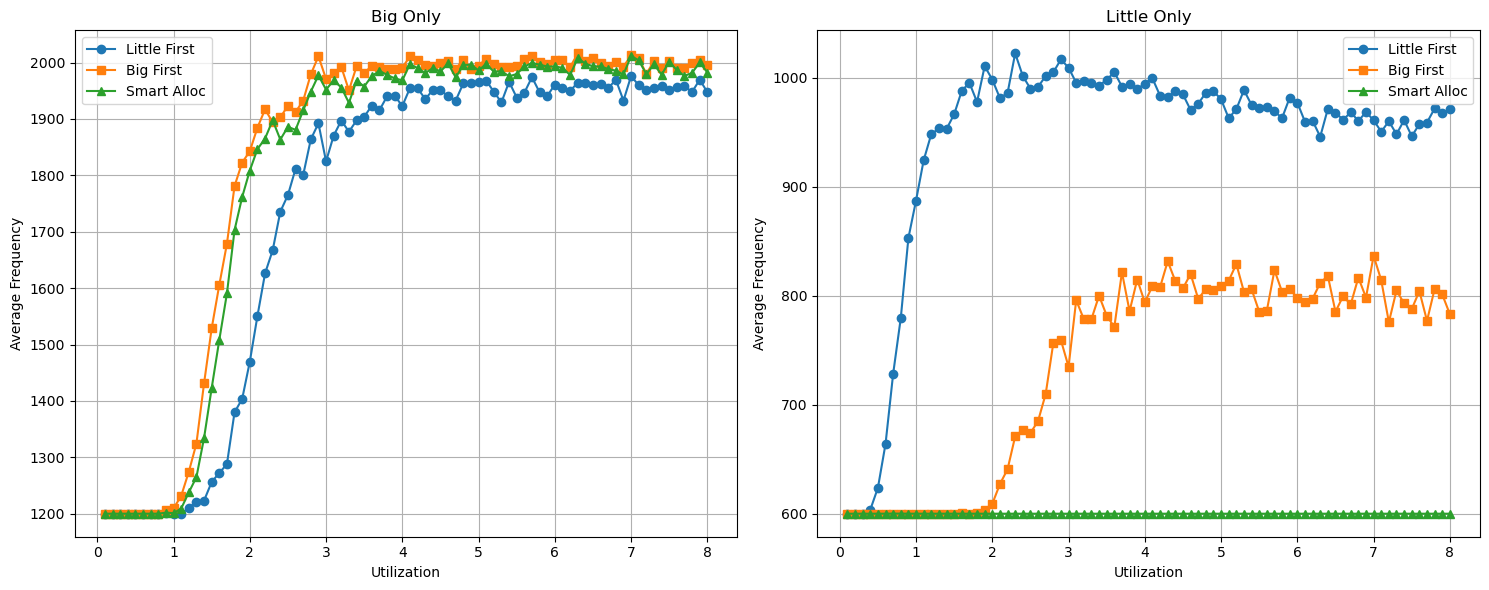

In [8]:
plt.figure(figsize=(15, 6))

fl = avg_freqs.filter(pl.col("cluster_id") == 1)
plt.subplot(1, 2, 1)
plt.plot(fl["utilization"], fl["avg_frequency_little_first_ffa"], label="Little First", marker='o')
plt.plot(fl["utilization"], fl["avg_frequency_big_first_ffa"], label="Big First", marker='s')
plt.plot(fl["utilization"], fl["avg_frequency_smart_ass_ffa"], label="Smart Alloc", marker='^')
plt.xlabel("Utilization")
plt.ylabel("Average Frequency")
plt.title("Big Only")
plt.legend()
plt.grid(True)

fl = avg_freqs.filter(pl.col("cluster_id") == 2)
plt.subplot(1, 2, 2)
plt.plot(fl["utilization"], fl["avg_frequency_little_first_ffa"], label="Little First", marker='o')
plt.plot(fl["utilization"], fl["avg_frequency_big_first_ffa"], label="Big First", marker='s')
plt.plot(fl["utilization"], fl["avg_frequency_smart_ass_ffa"], label="Smart Alloc", marker='^')
plt.xlabel("Utilization")
plt.ylabel("Average Frequency")
plt.title("Little Only")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
def compute_rejected(logs_dir):
    args = [SCHEDVIEW, "--platform", PLATFORM, "-d", logs_dir, "--index", "--rejected", "--arrivals"]
    df = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
    return df.with_columns((pl.col("rejected") / pl.col("arrivals")).alias("rejected-rates")).select(pl.col("rejected-rates")).mean()

rejected_rates = {}
for alloc in ["little_first", "big_first", "smart_ass"]:
    rejected_rates[alloc] = {}
    for sched in ["grub", "ffa", "csf"]:
        rejected_df = []
        for i in range(1, 81):
            rejected_df.append(compute_rejected(f"{DIR}_logs_{alloc}_{sched}/{i}").with_columns(utilizations=i/10))
        
        rejected_rates[alloc][sched] = pl.concat(rejected_df)

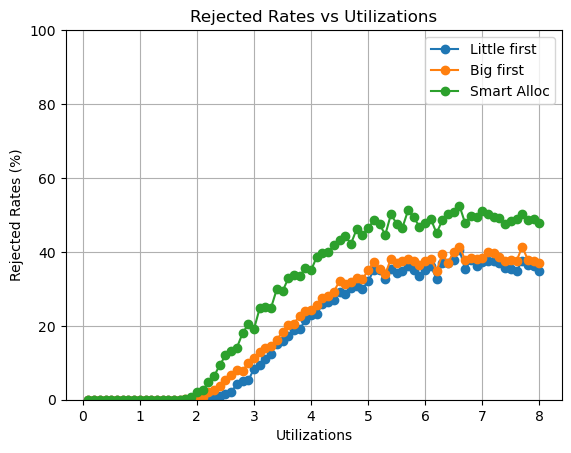

In [10]:
fig, ax = plt.subplots()
ax.plot(rejected_rates["little_first"]["grub"]["utilizations"], rejected_rates["little_first"]["grub"]["rejected-rates"] * 100, label="Little first", marker='o')
ax.plot(rejected_rates["little_first"]["grub"]["utilizations"], rejected_rates["big_first"]["grub"]["rejected-rates"] * 100, label="Big first", marker='o')
ax.plot(rejected_rates["little_first"]["grub"]["utilizations"], rejected_rates["smart_ass"]["grub"]["rejected-rates"] * 100, label="Smart Alloc", marker='o')
ax.set_ylim(0, 100)
ax.set_xlabel("Utilizations")
ax.set_ylabel("Rejected Rates (%)")
ax.set_title("Rejected Rates vs Utilizations")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
for plat in ["u1", "u2", "u3", "u4", "u5"]:
    for sched in ["grub", "ffa", "csf"]:
        print(f"-> {plat} {sched}")
        sim.simul(DIR, "smart_ass", sched, f"./platforms/exynos5422_{plat}.json", f"{DIR}_{plat}_logs")

-> u1 grub
-> u1 ffa
-> u1 csf
-> u2 grub
-> u2 ffa
-> u2 csf
-> u3 grub
-> u3 ffa
-> u3 csf
-> u4 grub
-> u4 ffa
-> u4 csf
-> u5 grub
-> u5 ffa
-> u5 csf


In [ ]:
def compute_migrated(logs_dir):
    args = [SCHEDVIEW, "--platform", PLATFORM, "-d", logs_dir, "--index", "--cluster_migration", "--arrivals"]
    df = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
    return df.with_columns((pl.col("cluster_migration") / pl.col("arrivals")).alias("migration-rates")).select(pl.col("migration-rates")).mean()

migration_rates = {}
for alloc in ["little_first", "big_first", "smart_ass"]:
    migration_rates[alloc] = {}
    for sched in ["grub", "ffa", "csf"]:
        migration_df = []
        for i in range(1, 81):    
            migration_df.append(compute_migrated(f"{DIR}_logs_{alloc}_{sched}/{i}").with_columns(utilizations=i/10))
        
        migration_rates[alloc][sched] = pl.concat(migration_df)

In [ ]:
allocations = ["smart_ass"]
schedulers = ["grub", "ffa", "csf"]

combinations = list(itertools.product(allocations, schedulers))

def worker(alloc, sched):
    freq = average_freq(f"{DIR}_logs_{alloc}_{sched}").rename({"avg_frequency": f"avg_frequency_{alloc}_{sched}"})
    return (alloc, sched, freq)

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(worker, alloc, sched) for alloc, sched in combinations]
    results = [future.result() for future in futures]

freqs = {}
for alloc, sched, freq in results:
    if alloc not in freqs:
        freqs[alloc] = {}
    freqs[alloc][sched] = freq